In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

In [2]:
fx = 800
fy = 800
cx = 0
cy = 0
s = 0

H = 480*2 # Hauteur de l'image en pixels
W = 640*2 # Largeur de l'image en pixels

K = np.array([[fx, s, cx],
              [0, fy, cy],  
                [0,   0,   1]]) # Matrice des paramètres intrinsèques de la caméra

A = np.array([[-1, 0, 0, W/2],
              [0, -1, 0, H/2],
                [0, 0, 1, 0]])  # Matrice de transformation des coordonnées écran aux coordonnées image

class camera_intrinseque:
    def __init__(self, K , A):
        self.K = K
        self.A = A  
    def project_point(self, P_camera):
        """
        Projette un point 3D dans le repère de la caméra sur le plan image.
        P_camera : coordonnées du point dans le repère de la caméra (x, y, z)
        Retourne les coordonnées 2D du point projeté sur le plan image (u, v)
        """
        x, y, z = P_camera
        if z <= 0:
            return None  # Le point est derrière la caméra
        I_ecran = K @ P_camera[:3]
        # Conversion en coordonnées inhomogènes
        I_ecran = np.round(I_ecran[:2] / I_ecran[2])
        I_image = A @np.hstack((I_ecran, np.array([0., 1.])))
        v, u = I_image[:2]  
        return np.array([v, u])
  
camera = camera_intrinseque(K, A)
W


1280

In [3]:
# Calculer l'inverse d'une matrice 

def invert_matrix(mat):
    """
    Retourne l'inverse de `mat` ou lève une exception si non inversible.
    """
    try:
        return np.linalg.inv(mat)
    except np.linalg.LinAlgError:
        raise ValueError("Matrice singulière : impossible d'appliquer l'inverse.")


In [4]:
R_camera_to_word = np.array([[0, 1, 0 ],
                             [0, 0, -1 ],   
                             [-1, 0, 0]]) # Rotation de la camera vers le repère monde ou changement de base du monde vers la camera
R_word_to_camera = invert_matrix(R_camera_to_word) # Rotation du repère monde vers la camera ou changement de base de la camera vers le monde


C_word_to_camera = R_camera_to_word # changement de base du monde vers la camera ou rotation de la camera vers le repère monde

C_camera_to_word = R_word_to_camera # changement de base de la camera vers le monde ou rotation du repère monde vers la camera

In [5]:
l = 50  # distance entre l'origine du repère monde et l'origine du repère camera le long de y dans le repère monde
O_w = np.array([0,0,0])
O_c = np.array([0,l,0])

In [6]:
class Repere:

    def __init__(self, origine = np.array([0, 0, 0]), R=np.eye(3)):
        self.rotation = R
        self.i = np.array([1, 0, 0]) @ self.rotation
        self.j = np.array([0, 1, 0]) @ self.rotation
        self.k = np.array([0, 0, 1]) @ self.rotation
        # self.i = self.rotation[:, 0]
        # self.j = self.rotation[:, 1]
        # self.k = self.rotation[:, 2]
        self.origine = origine
    def coordonnees_point_dans_ce_repere(self, point_global):
        """
        Calcule les coordonnées d'un point global dans ce repère.
        """
        vecteur = point_global - self.origine
        x = np.dot(vecteur, self.i)
        y = np.dot(vecteur, self.j)
        z = np.dot(vecteur, self.k)
        return np.array([x, y, z])
    def coordonnees_point_dans_repere_monde(self, point_local):
        """
        Calcule les coordonnées d'un point local dans le repère monde.
        """
        return (point_local[0] * self.i +
                point_local[1] * self.j +
                point_local[2] * self.k +
                self.origine)

In [7]:
Repere_W = Repere(origine=O_w)
Repere_C = Repere(O_c, R=R_word_to_camera )

In [8]:
Repere_C.i

array([ 0.,  0., -1.])

In [9]:
M_world =np.array([15.,  10., -5.,   1.])
M_camera = Repere_C.coordonnees_point_dans_ce_repere(M_world[:3])
print("Coordonnées de M dans le repère de la caméra :", M_camera)
M_world = Repere_C.coordonnees_point_dans_repere_monde(M_camera)
print("Coordonnées de M dans le repère monde :", M_world)

Coordonnées de M dans le repère de la caméra : [ 5. 15. 40.]
Coordonnées de M dans le repère monde : [15. 10. -5.]


In [10]:
def project_point(M_world):
    M_camera = Repere_C.coordonnees_point_dans_ce_repere(M_world[:3])
    I_image  = camera.project_point(M_camera)
    print(I_image)  
    return I_image  

In [11]:
I_image = project_point(M_world)
I_image

[540. 180.]


array([540., 180.])

Définissons certains points dans le repere camera qui forme un triangle

In [12]:
d = 15
alpha_camera = np.array([d, d, l, 1])
beta_camera = np.array([-d, d, l, 1])
gamma_camera = np.array([0, -d, l, 1])

Trouvons leurs coordonées dans le rèpere monde.

In [13]:
alpha_monde = Repere_C.coordonnees_point_dans_repere_monde(alpha_camera[:3])
beta_monde = Repere_C.coordonnees_point_dans_repere_monde(beta_camera[:3])
gamma_monde = Repere_C.coordonnees_point_dans_repere_monde(gamma_camera[:3])

In [14]:
print(alpha_monde, beta_monde, gamma_monde)

[ 15.   0. -15.] [15.  0. 15.] [-15.   0.   0.]


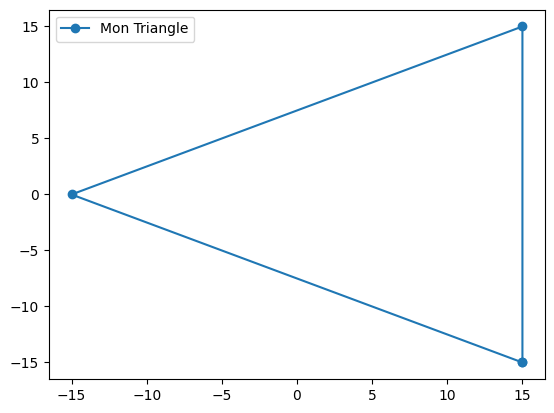

In [15]:
points_x = [alpha_monde[0], beta_monde[0], gamma_monde[0], alpha_monde[0]]
points_y = [alpha_monde[2], beta_monde[2], gamma_monde[2], alpha_monde[2]]

# 2. On affiche tout en une seule ligne
# 'o-' signifie : marqueurs ronds ('o') reliés par des lignes ('-')
plt.figure()
plt.plot(points_x, points_y, 'o-', label='Mon Triangle')

# Optionnel : Si c'est pour une image, l'axe Y est souvent inversé en informatique
# plt.gca().invert_yaxis() 

plt.legend()
plt.show()

In [16]:
alpha_image = project_point(alpha_monde)
beta_image = project_point(beta_monde)
gamma_image = project_point(gamma_monde)

[400. 240.]
[880. 240.]
[640. 720.]


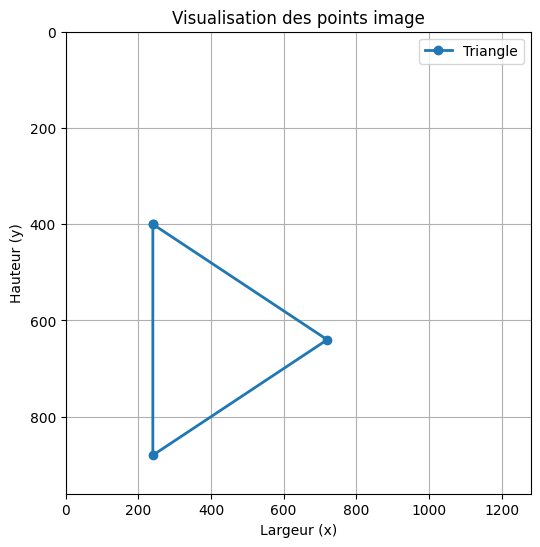

In [17]:

# Vos points
p1 = alpha_image
p2 = beta_image
p3 =  gamma_image
# 1. Création des listes X et Y
# On répète p1 à la fin pour fermer le tracé du triangle
x_coords = [p1[1], p2[1], p3[1], p1[1]]
y_coords = [p1[0], p2[0], p3[0], p1[0]]

plt.figure(figsize=(6, 6))

# 2. Tracé
plt.plot(x_coords, y_coords, 'o-', linewidth=2, label='Triangle')

# 3. Configuration du repère "Image"
# Pour avoir l'origine (0,0) en HAUT à gauche comme une image :
plt.gca().invert_yaxis() 

# Optionnel : Fixer les limites pour voir toute l'image (W=1280, H=960)
plt.xlim(0, 1280) 
plt.ylim(960, 0) # Notez l'inversion ici aussi (Max -> Min)

plt.title("Visualisation des points image")
plt.xlabel("Largeur (x)")
plt.ylabel("Hauteur (y)")
plt.grid(True)
plt.legend()
plt.show()

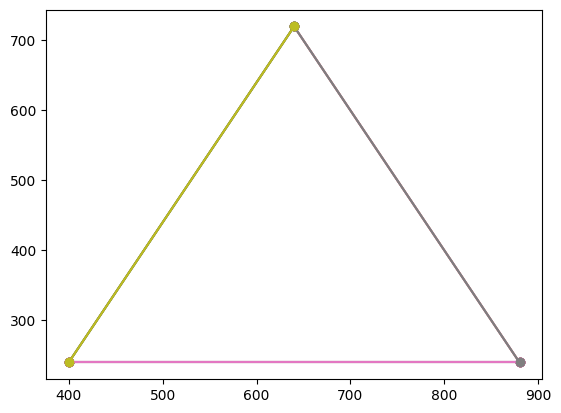

In [18]:
for i in range(3):
    plt.plot([alpha_image[0], beta_image[0]], [alpha_image[1], beta_image[1]], 'o-')
    plt.plot([beta_image[0], gamma_image[0]], [beta_image[1], gamma_image[1]], 'o-')
    plt.plot([gamma_image[0], alpha_image[0]], [gamma_image[1], alpha_image[1]], 'o-')



plt.show()